# Sweeping method for TN training
***Anomaly detection with Spaced Matrix Product Operator trained using Sweeping method***

- images resized to $7\times7$ resolution due to slower training of this procedure

In [1]:
import os
os.environ["KMP_WARNINGS"] = "0"
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *
import matplotlib.pyplot as plt
from sklearn.metrics import auc

from tn4ml.initializers import *
from tn4ml.models.smpo import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.metrics import *
from tn4ml.eval import *
from tn4ml.util import *

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')

### Load dataset
- normalize to $[0, 1]$ range

In [3]:
train, test = mnist.load_data()
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

In [4]:
normal_class = 0

In [5]:
# training data
X = {
"normal": data["X"]["train"][data["y"]["train"] == normal_class]/255.,
"anomaly": data["X"]["train"][data["y"]["train"] != normal_class]/255.,
}

In [6]:
# test data
X_test = {
"normal": data["X"]["test"][data["y"]["test"] == normal_class]/255.,
"anomaly": data["X"]["test"][data["y"]["test"] != normal_class]/255.,
}

In [7]:
# reduce size of images for faster training and reduce to 0-1 range
strides = (4,4) # (2,2) for 14x14 images; (4,4) for 7x7 images
pool_size = (2,2)
pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding="same")

In [27]:
X_resized = {
    "normal": pool(tf.constant(X["normal"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7),
    "anomaly": pool(tf.constant(X["anomaly"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7),
}

X_test_resized = {
    "normal": pool(tf.constant(X_test["normal"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7),
    "anomaly": pool(tf.constant(X_test["anomaly"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7),
}

### Rearrange pixels in zig-zag order
- (from https://arxiv.org/pdf/1605.05775.pdf)

<img src="images/zig-zag.png" alt="MPS Params" width="150" height="150">

In [28]:
def zigzag_order(data):
    data = np.squeeze(data)
    data_zigzag = []
    for x in data:
        image = []
        for i in x:
            image.extend(i)
        data_zigzag.append(image)
    return np.asarray(data_zigzag)

In [29]:
zigzag = True

In [30]:
if zigzag:
    train_normal = zigzag_order(X_resized["normal"])
    test_normal = zigzag_order(X_test_resized["normal"])

    train_anomaly = zigzag_order(X_resized["anomaly"])
    test_anomaly = zigzag_order(X_test_resized["anomaly"])
else:
    train_normal = X_resized['normal'].reshape(-1, X_resized['normal'].shape[1]*X_resized['normal'].shape[2])
    test_normal = X_test_resized['normal'].reshape(-1, X_test_resized['normal'].shape[1]*X_test_resized['normal'].shape[2])

    train_anomaly = X_resized['anomaly'].reshape(-1, X_resized['anomaly'].shape[1]*X_resized['anomaly'].shape[2])
    test_anomaly = X_test_resized['anomaly'].reshape(-1, X_test_resized['anomaly'].shape[1]*X_test_resized['anomaly'].shape[2])

In [31]:
# take train_size samples from normal class for training
train_size = 2048

indices = list(range(len(train_normal)))
np.random.shuffle(indices)

indices = indices[:train_size]
train_normal = np.take(train_normal, indices, axis=0)

### Training setup

In [13]:
# define model parameters
L = 7*7
initializer = gramschmidt('normal', 1e-5)
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 10
phys_dim = (2,2)
spacing = 8
add_identity = False
boundary='obc'

In [14]:
model = SMPO_initialize(L=L,
                        initializer=initializer,
                        key=key,
                        shape_method=shape_method,
                        spacing=spacing,
                        bond_dim=bond_dim,
                        phys_dim=phys_dim,
                        cyclic=False,
                        compress=True,
                        add_identity=add_identity,
                        boundary=boundary)

In [15]:
alpha = 0.4
def loss_combined(*args, **kwargs):
    error = LogQuadNorm
    reg = LogReLUFrobNorm
    return CombinedLoss(*args, **kwargs, error=error, reg=lambda P: alpha*reg(P))

In [ ]:
# define training parameters
epochs = 100
batch_size = 256
optimizer = optax.adam
strategy = 'sweeps'
loss = loss_combined
train_type = TrainingType.UNSUPERVISED
embedding = trigonometric()
learning_rate = 1e-4
earlystop = EarlyStopping(min_delta=0, patience=10, monitor='loss', mode='min')

model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [17]:
history = model.train(train_normal,
            epochs=epochs,
            batch_size=batch_size,
            embedding = embedding,
            normalize = True,
            dtype = jnp.float64,
            earlystop = earlystop,
            cache=False, # for sweeping strategy no cache because of memory issues
            )


epoch:   3%|▎          3/100 , loss=4898.5405 

Waiting for 1 epochs.


epoch:   4%|▍          4/100 , loss=4916.9816

Waiting for 2 epochs.


epoch:   5%|▌          5/100 , loss=4906.0683

Waiting for 3 epochs.


epoch:   8%|▊          8/100 , loss=4882.4867

Waiting for 1 epochs.


epoch:  10%|█          10/100 , loss=4880.3916

Waiting for 1 epochs.


epoch:  11%|█          11/100 , loss=4881.7900

Waiting for 2 epochs.


epoch:  12%|█▏         12/100 , loss=4898.7627

Waiting for 3 epochs.


epoch:  15%|█▌         15/100 , loss=4872.9330

Waiting for 1 epochs.


epoch:  16%|█▌         16/100 , loss=4881.6928

Waiting for 2 epochs.


epoch:  20%|██         20/100 , loss=4858.8395

Waiting for 1 epochs.


epoch:  21%|██         21/100 , loss=4862.0073

Waiting for 2 epochs.


epoch:  24%|██▍        24/100 , loss=4847.9034

Waiting for 1 epochs.


epoch:  26%|██▌        26/100 , loss=4845.9629

Waiting for 1 epochs.


epoch:  28%|██▊        28/100 , loss=4842.7239

Waiting for 1 epochs.


epoch:  29%|██▉        29/100 , loss=4844.3363

Waiting for 2 epochs.


epoch:  30%|███        30/100 , loss=4848.4053

Waiting for 3 epochs.


epoch:  31%|███        31/100 , loss=4847.3821

Waiting for 4 epochs.


epoch:  32%|███▏       32/100 , loss=4858.1263

Waiting for 5 epochs.


epoch:  33%|███▎       33/100 , loss=4852.0553

Waiting for 6 epochs.


epoch:  34%|███▍       34/100 , loss=4847.9779

Waiting for 7 epochs.


epoch:  38%|███▊       38/100 , loss=4827.4997

Waiting for 1 epochs.


epoch:  39%|███▉       39/100 , loss=4828.9107

Waiting for 2 epochs.


epoch:  40%|████       40/100 , loss=4829.7398

Waiting for 3 epochs.


epoch:  42%|████▏      42/100 , loss=4822.7272

Waiting for 1 epochs.


epoch:  43%|████▎      43/100 , loss=4832.1619

Waiting for 2 epochs.


epoch:  44%|████▍      44/100 , loss=4830.2362

Waiting for 3 epochs.


epoch:  45%|████▌      45/100 , loss=4825.7658

Waiting for 4 epochs.


epoch:  46%|████▌      46/100 , loss=4837.0979

Waiting for 5 epochs.


epoch:  47%|████▋      47/100 , loss=4830.5170

Waiting for 6 epochs.


epoch:  48%|████▊      48/100 , loss=4834.8636

Waiting for 7 epochs.


epoch:  50%|█████      50/100 , loss=4817.3382

Waiting for 1 epochs.


epoch:  51%|█████      51/100 , loss=4819.6702

Waiting for 2 epochs.


epoch:  53%|█████▎     53/100 , loss=4814.1478

Waiting for 1 epochs.


epoch:  58%|█████▊     58/100 , loss=4802.9595

Waiting for 1 epochs.


epoch:  59%|█████▉     59/100 , loss=4812.1689

Waiting for 2 epochs.


epoch:  60%|██████     60/100 , loss=4803.7250

Waiting for 3 epochs.


epoch:  61%|██████     61/100 , loss=4826.8882

Waiting for 4 epochs.


epoch:  62%|██████▏    62/100 , loss=4811.7140

Waiting for 5 epochs.


epoch:  63%|██████▎    63/100 , loss=4805.7986

Waiting for 6 epochs.


epoch:  64%|██████▍    64/100 , loss=4809.9926

Waiting for 7 epochs.


epoch:  66%|██████▌    66/100 , loss=4798.8627

Waiting for 1 epochs.


epoch:  67%|██████▋    67/100 , loss=4802.2691

Waiting for 2 epochs.


epoch:  68%|██████▊    68/100 , loss=4804.7045

Waiting for 3 epochs.


epoch:  69%|██████▉    69/100 , loss=4812.5455

Waiting for 4 epochs.


epoch:  70%|███████    70/100 , loss=4808.0869

Waiting for 5 epochs.


epoch:  71%|███████    71/100 , loss=4800.1221

Waiting for 6 epochs.


epoch:  72%|███████▏   72/100 , loss=4805.0641

Waiting for 7 epochs.


epoch:  73%|███████▎   73/100 , loss=4803.9018

Waiting for 8 epochs.


epoch:  74%|███████▍   74/100 , loss=4807.6348

Waiting for 9 epochs.


epoch:  75%|███████▌   75/100 , loss=4811.4392

Training stopped by EarlyStopping on epoch: 65


epoch:  76%|███████▌   76/100 , loss=4806.6447


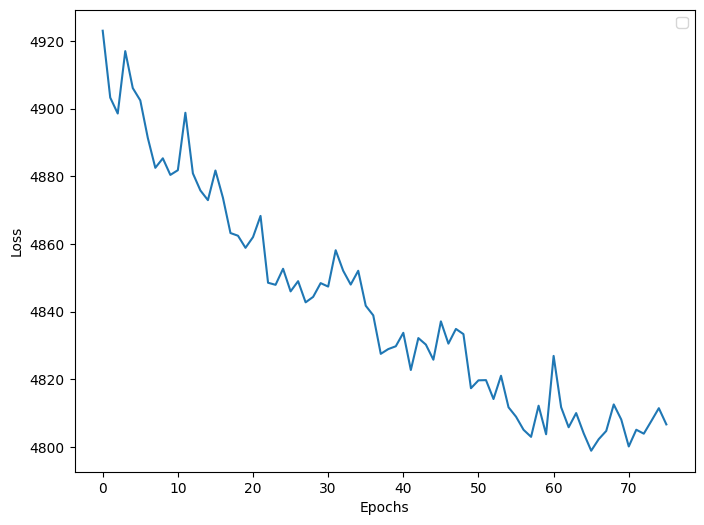

In [18]:
plot_loss(model.history, validation=False, figsize=(8, 6))

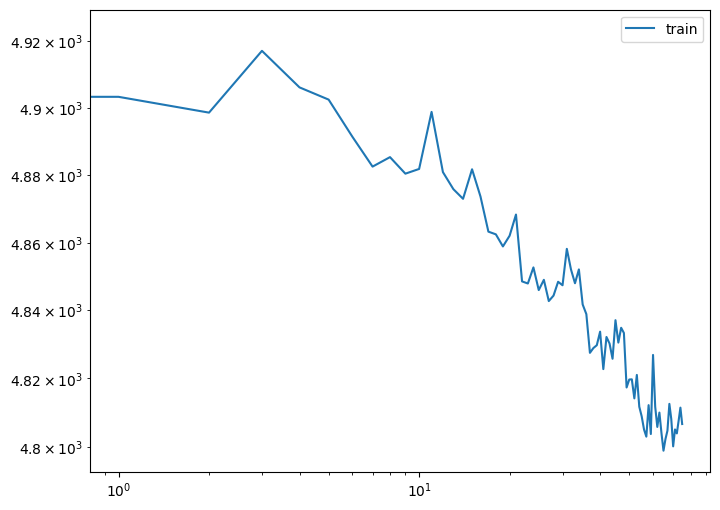

In [19]:
# plot loss
plt.figure(figsize=(8, 6))
plt.loglog(range(len(history['loss'])), history['loss'], label='train')
plt.legend()
plt.show()

**Evaluate**

In [32]:
indices = list(range(len(test_anomaly)))
np.random.shuffle(indices)

indices = indices[:len(test_normal)]
test_anomaly = np.take(test_anomaly, indices, axis=0)

In [33]:
test_anomaly.shape, test_normal.shape

((980, 49), (980, 49))

In [ ]:
loss = LogQuadNorm

anomaly_score = model.evaluate(test_anomaly, evaluate_type=train_type, return_list=True, dtype=jnp.float64, batch_size=128, embedding=embedding, metric = loss)
normal_score = model.evaluate(test_normal, evaluate_type=train_type, return_list=True, dtype=jnp.float64, batch_size=128, embedding=embedding, metric = loss)

In [35]:
anomaly_score.shape, normal_score.shape

((896,), (896,))

In [39]:
fpr, tpr = get_roc_curve_data(anomaly_score, normal_score, anomaly_det=True)
auc_value = auc(fpr, tpr)

**Plot anomaly scores and ROC curve**

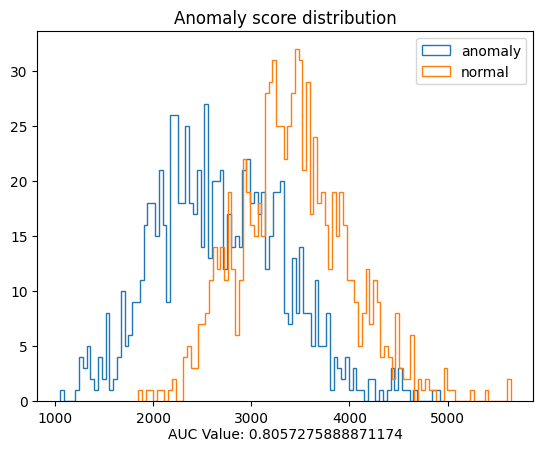

In [40]:
plt.figure()
plt.hist(anomaly_score, bins=100, histtype='step', label='anomaly')
plt.hist(normal_score, bins=100, histtype='step', label='normal')
plt.title('Anomaly score distribution')
plt.legend()
plt.text(0.5, -0.1, f'AUC Value: {auc_value}', ha='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()

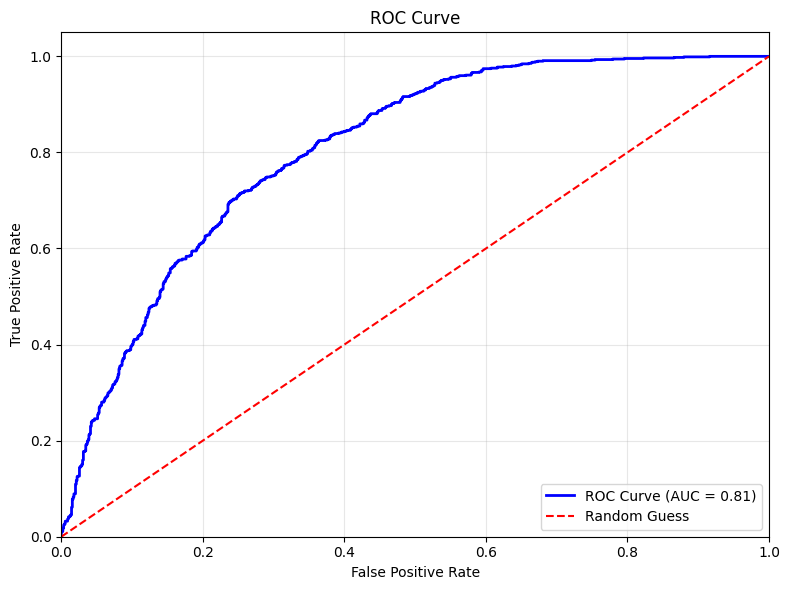

In [41]:
# Plot ROC curve
plot_ROC_curve_from_data(fpr, tpr)
